<a href="https://colab.research.google.com/github/Antana-A/Predicting-Protein-Expression-from-Gene-Expression-/blob/main/Final_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction


**CITE-seq** is a single-cell sequencing technique that measures both gene and protein expression, enabling deeper insights into cell identity. In this project, we aimed to predict protein expression profiles of 25 proteins across 1000 test cells using gene expression data from 639 genes. We experimented with a **multivariate regression** model, a **non-negative matrix factorization (NMF)** approach, and a **deep learning model**. The models were evaluated using Pearson Correlation Coefficient, with the goal of accurately capturing the relationships between transcriptional and protein-level data.

## Importing Necessary Libraries and Datasets

We first import the necessary libraries required for the entire project. They span across numpy implementations, torch for neural networks, matplotlib for visualization and sklearn for scaling data.

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [3]:

# Load training RNA data, ensuring the first column (index) is not treated as data
path1 = "https://raw.githubusercontent.com/Antana-A/Predicting-Protein-Expression-from-Gene-Expression-/refs/heads/main/training_set_rna.csv"
training_rna_df = pd.read_csv(path1, index_col=0)


# Load training ADT data, ensuring the first column (index) is not treated as data
path2 = "https://raw.githubusercontent.com/Antana-A/Predicting-Protein-Expression-from-Gene-Expression-/refs/heads/main/training_set_adt.csv"
training_adt_df = pd.read_csv(path2, index_col=0)


# Load test RNA data, ensuring the first column (index) is not treated as data
path3 = "https://raw.githubusercontent.com/Antana-A/Predicting-Protein-Expression-from-Gene-Expression-/refs/heads/main/test_set_rna.csv"
test_rna_df = pd.read_csv(path3, index_col=0)


# Check the shapes again
print('Training RNA shape:', training_rna_df.shape)  # Expected: (4000, 639)
print('Training ADT shape:', training_adt_df.shape)  # Expected: (4000, 25)
print('Test RNA shape:', test_rna_df.shape)          # Expected: (1000, 639)

Training RNA shape: (639, 4000)
Training ADT shape: (25, 4000)
Test RNA shape: (639, 1000)


## Multivariate Regression Model

In this implementation, the model uses the normal linear equation without a bias term to fit a linear relationship between RNA features and protein expression, and is evaluated using Pearson Correlation Coefficient to determine how well the predictions correlate with the true protein values. The goal of this approach was to establish a **simple, interpretable baseline model** before exploring more complex methods. Our kaggle results were **0.81225** for the base model, which was an excellent start.

We started by defining two functions that calculate the beta coefficient for each \(X\), using the Ordinary Least Squares formula:

$$
\beta = (X^T X)^{-1} X^T y
$$


In [4]:


def fit_linear_regression_no_bias(X, Y):
    """
    Fits a linear regression model using the normal equation without a bias term.
    Args:
        X: Feature matrix (num_samples, num_features)
        Y: Target matrix (num_samples, num_targets)
    Returns:
        beta: Coefficient matrix (num_features, num_targets)
    """
    # X has shape (4000, 639), Y has shape (4000, 25)
    # Step 1: Compute the normal equation without bias term
    beta = np.linalg.inv(X.T @ X) @ (X.T @ Y)  # X.T has shape (639, 4000), Y has shape (4000, 25)

    # beta will have shape (639, 25)
    return beta

def predict_linear_regression_no_bias(X, beta):
    """
    Makes predictions using the linear regression model without a bias term.
    Args:
        X: Feature matrix (num_samples, num_features)
        beta: Coefficient matrix (num_features, num_targets)
    Returns:
        Y_pred: Predicted targets (num_samples, num_targets)
    """
    # X has shape (1000, 639) for test data
    # Step 1: Perform prediction without bias: Y_pred = X * beta
    Y_pred = X @ beta  # X has shape (1000, 639), beta has shape (639, 25)

    # Y_pred will have shape (1000, 25)
    return Y_pred


We then transposed our data to the correct shape to allow for a vectorize multiplication.

In [5]:
# Transpose RNA and ADT data to correct the shape
training_rna = training_rna_df.T  # Transpose to get shape (4000, 639)
training_adt = training_adt_df.T  # Transpose to get shape (4000, 25)
test_rna = test_rna_df.T          # Transpose to get shape (1000, 639)

# Check the shapes again
print('Training RNA shape (after transpose):', training_rna.shape)  # Should be (4000, 639)
print('Training ADT shape (after transpose):', training_adt.shape)  # Should be (4000, 25)
print('Test RNA shape (after transpose):', test_rna.shape)          # Should be (1000, 639)


Training RNA shape (after transpose): (4000, 639)
Training ADT shape (after transpose): (4000, 25)
Test RNA shape (after transpose): (1000, 639)


We then fit out data to our model by calling the fit_linear_regression_no_bias function.

In [6]:
# Fit the model using the transposed DataFrames
beta = fit_linear_regression_no_bias(training_rna, training_adt)


In [7]:
# Convert beta to a NumPy array to bypass pandas index alignment
adt_predictions = predict_linear_regression_no_bias(test_rna, beta.to_numpy())

We then decided to do a train-test split our training data into two to create a validation set as our initial submission didn't perform as well. We then fit our model to the simple cross-validation data.

In [8]:
# Set the split ratio
split_ratio = 0.8
num_samples = training_rna.shape[0]
split_index = int(split_ratio * num_samples)

# Split the data
X_train = training_rna[:split_index]
Y_train = training_adt[:split_index]
X_val = training_rna[split_index:]
Y_val = training_adt[split_index:]


In [9]:
# Fit the model
beta_cv = fit_linear_regression_no_bias(X_train, Y_train)


In [10]:
# Predict ADT values for validation RNA data
Y_pred = predict_linear_regression_no_bias(X_val, beta_cv.to_numpy())


We then defined a function to calculate the pearson correlation and called it to see our model's performance.

In [11]:
def pearson_corr(y_true, y_pred):
    """
    Computes the Pearson Correlation Coefficient for each feature.
    Args:
        y_true: True values (num_samples, num_features)
        y_pred: Predicted values (num_samples, num_features)
    Returns:
        correlations: Array of correlation coefficients (num_features,)
    """

    # Convert y_true to a NumPy array if it's a DataFrame
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.to_numpy()

    # Convert y_pred to a NumPy array if it's a DataFrame
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.to_numpy()

    num_features = y_true.shape[1]
    correlations = np.zeros(num_features)
    for i in range(num_features):
        x = y_true[:, i]
        y = y_pred[:, i]
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        numerator = np.sum((x - x_mean) * (y - y_mean))
        denominator = np.sqrt(np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2))
        correlations[i] = numerator / denominator
    return correlations

In [12]:
# Compute Pearson Correlation Coefficient
correlations = pearson_corr(Y_val, Y_pred)
average_correlation = np.mean(correlations)
print('Average Pearson Correlation:', average_correlation)


Average Pearson Correlation: 0.7390155463271261


Confident of our perfromance, we then trained the model on the test data and created a submission file. We attained a 0.81225 pearson correlation score.

In [13]:
# Retrain on full training data
beta_final = fit_linear_regression_no_bias(training_rna, training_adt)

# Predict on test data
adt_predictions_test = predict_linear_regression_no_bias(test_rna, beta_final.to_numpy()) # Remove transpose (.T) from  beta_final to align for matrix multiplication

In [14]:
# Create the submission file
adt_predictions_flattened = adt_predictions_test.to_numpy().flatten()  # Convert to NumPy array before flattening
ids = ['ID_' + str(i + 1) for i in range(len(adt_predictions_flattened))]
submission_df = pd.DataFrame({'Id': ids, 'expected': adt_predictions_flattened})
submission_df.to_csv('linear_regression_submission_file.csv', index=False)

### Visualizing Our Submissions

#### Predicted Vs. True Values


We decided to use a scatterplot to visualize the relationship between the predicted values obtained from our linear regression model and the actual true values from our dataset.

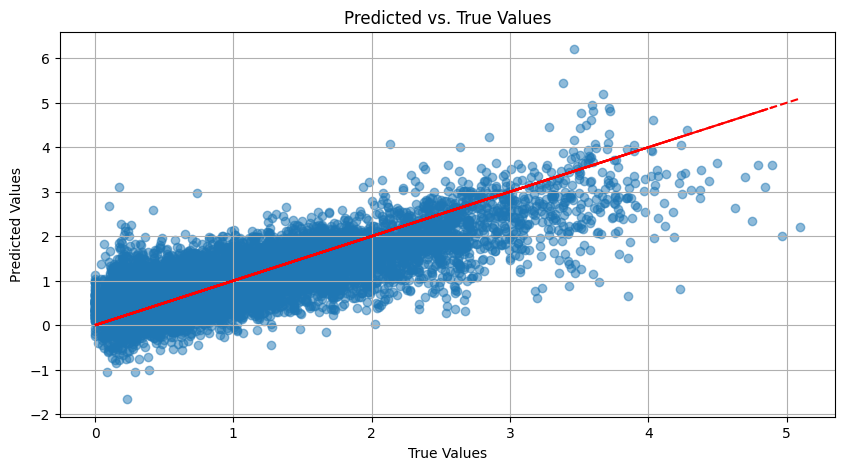

In [15]:
import matplotlib.pyplot as plt

# Plotting the predicted vs. true values
true_values = Y_val
predicted_values = Y_pred
#plotting the scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(true_values, predicted_values, alpha=0.5)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.grid(True)
plt.savefig('predicted_vs_true_values.png')
plt.show()

There is a noticeable positive correlation between the predicted and true values. As the true values increase, the predicted values also tend to increase, indicating that the model captures the general trend in the data effectively. Additionally, most scatter points are close to the ideal line(red) suggesting that the model performs well in making predictions for most data points.

#### Feature Coefficients Barplot


Moreover, we did a visualization of the feature coefficients outputed by the model and their respective relationship to the target variable. Features with positive coefficients indicate a positive correlation with the target. This means that as the value of the feature increases, the predicted target value also tends to increase. Conversely, features with negative coefficients indicate a negative correlation, suggesting that as the feature value increases, the predicted target value tends to decrease.

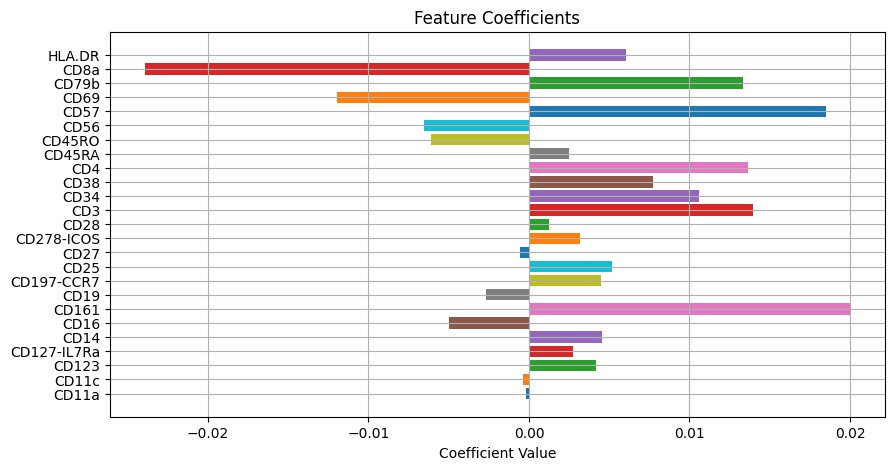

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming beta contains the coefficients from your model
#feature_names = ['Feature1', 'Feature2', 'Feature3']  # Replace with actual feature names

# Get the actual column names from the DataFrame
feature_names = beta.columns

plt.figure(figsize=(10, 5))

# Use .to_numpy() to convert the DataFrame to a NumPy array
# Ensure that the number of feature names matches the number of coefficients
# to be plotted. Use beta.shape[1] to ensure it matches.
# and loop through the coefficients to plot each one.
for i in range(min(len(feature_names), beta.shape[1])):
    plt.barh(feature_names[i], beta.to_numpy()[0][i])

plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients')
plt.grid(True)
plt.savefig('feature_coefficients.png')
plt.show()

Features with coefficients close to zero (short bars), such as CD11a,suggest a weak relationship with the target, indicating that these features may not significantly influence the predictions.


## Deep Learning

This section presents a deep learning model that utilizes a feedforward neural network to predict outcomes based on 639 input features. The architecture comprises multiple fully connected layers, starting with a transformation to 1024 dimensions, followed by successive layers with 512, 256, and 128 neurons, ultimately leading to an output layer of 25 neurons for class predictions. Dropout layers with a rate of 0.3 are incorporated after each fully connected layer to mitigate overfitting, while batch normalization is applied after the first three layers to stabilize training and enhance convergence. This design aims to capture complex patterns in the data, making the model effective for prediction tasks.

Moreover, we used the adam optimizer to get quicker to a local minima, added an early stop to prevent overfitting, and trained the data over 50 epochs.

The first step was to split the data into training and test data.

In [17]:
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(training_rna, training_adt, test_size=0.2, random_state=42)

Feature scaling, specifically standardization, is crucial in preparing our data for modeling. It ensures that all features contribute equally to the learning process by transforming them to have a mean of 0 and a standard deviation of 1. This helps improve convergence speed and overall model performance

In [18]:
# Feature Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_rna_scaled = scaler.transform(test_rna)

We then convert the data to pytorch tensors and create dataloader objects for batching.

In [19]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32) # Convert DataFrame to NumPy array using .values
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32) # Convert DataFrame to NumPy array using .values
test_rna_tensor = torch.tensor(test_rna_scaled, dtype=torch.float32)


In [20]:
# Create DataLoader objects for efficient batching
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Network Architecture

Our neural network architecture consists of five fully connected layers, with input of 639 features,progressively reducing the dimensionality from 1024 to 25 output classes. To enhance model performance and prevent overfitting, dropout layers with a rate of 0.3 are incorporated after each hidden layer, while batch normalization is applied to stabilize the learning process and accelerate convergence. The use of Leaky ReLU activations introduces non-linearity, allowing the model to capture complex patterns in the data effectively.

In [21]:

# Define the PyTorch Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(639, 1024)  # Increased complexity
        self.dropout1 = nn.Dropout(0.3)  # Reduced dropout
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(256, 128)
        self.dropout4 = nn.Dropout(0.3)
        self.fc5 = nn.Linear(128, 25)
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.bn1(nn.LeakyReLU()(self.fc1(x)))
        x = self.dropout1(x)
        x = self.bn2(nn.LeakyReLU()(self.fc2(x)))
        x = self.dropout2(x)
        x = self.bn3(nn.LeakyReLU()(self.fc3(x)))
        x = self.dropout3(x)
        x = self.bn4(nn.LeakyReLU()(self.fc4(x)))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

In [22]:
# Instantiate the model, define loss function and optimizer
model = NeuralNetwork()
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
# Early stopping criteria
early_stop_patience = 10
best_val_loss = float('inf')
early_stop_counter = 0

In [24]:
# Before the training loop
train_losses = []
val_losses = []
num_epochs = 50
# Your existing training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()  # Backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()  # Update the weights
        running_loss += loss.item()

    # Validation step
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for X_batch, Y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            val_loss += loss.item()

    scheduler.step(val_loss)  # Update learning rate based on validation loss

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Append the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch [1/50], Loss: 0.6017, Validation Loss: 0.1662
Epoch [2/50], Loss: 0.2239, Validation Loss: 0.1542
Epoch [3/50], Loss: 0.1816, Validation Loss: 0.1403
Epoch [4/50], Loss: 0.1650, Validation Loss: 0.1375
Epoch [5/50], Loss: 0.1543, Validation Loss: 0.1376
Epoch [6/50], Loss: 0.1428, Validation Loss: 0.1416
Epoch [7/50], Loss: 0.1383, Validation Loss: 0.1340
Epoch [8/50], Loss: 0.1322, Validation Loss: 0.1327
Epoch [9/50], Loss: 0.1305, Validation Loss: 0.1370
Epoch [10/50], Loss: 0.1289, Validation Loss: 0.1312
Epoch [11/50], Loss: 0.1245, Validation Loss: 0.1303
Epoch [12/50], Loss: 0.1226, Validation Loss: 0.1327
Epoch [13/50], Loss: 0.1212, Validation Loss: 0.1328
Epoch [14/50], Loss: 0.1174, Validation Loss: 0.1306
Epoch [15/50], Loss: 0.1143, Validation Loss: 0.1297
Epoch [16/50], Loss: 0.1110, Validation Loss: 0.1294
Epoch [17/50], Loss: 0.1094, Validation Loss: 0.1304
Epoch [18/50], Loss: 0.1093, Validation Loss: 0.1317
Epoch [19/50], Loss: 0.1086, Validation Loss: 0.1301
Ep

#### Creating the submission file
We converted the predictions to a numpy array that was flattened to create a submission file submitted to Kaggle. Our best model had a Pearson Correlation value of **0.85719**.

In [25]:
# Make predictions on the test set
model.eval()
with torch.no_grad():
    adt_predictions_test = model(test_rna_tensor).cpu().numpy()

In [26]:
# Create the submission file
adt_predictions_flattened = adt_predictions_test.flatten()  # Flatten to get 25,000 entries
ids = ['ID_' + str(i + 1) for i in range(len(adt_predictions_flattened))]
submission_df = pd.DataFrame({'Id': ids, 'expected': adt_predictions_flattened})
submission_df.to_csv('7_leaky_pytorch_neural_network_submission_file.csv', index=False)

print("Neural network model trained, and submission file created!")

Neural network model trained, and submission file created!


### Visualizing Our Submissions

#### Predict Vs True Values, Residuals Scatterplots.

We created a scatter plot of predicted vs true values. The model seems to match the two quite well, with most values falling on the ideal line.

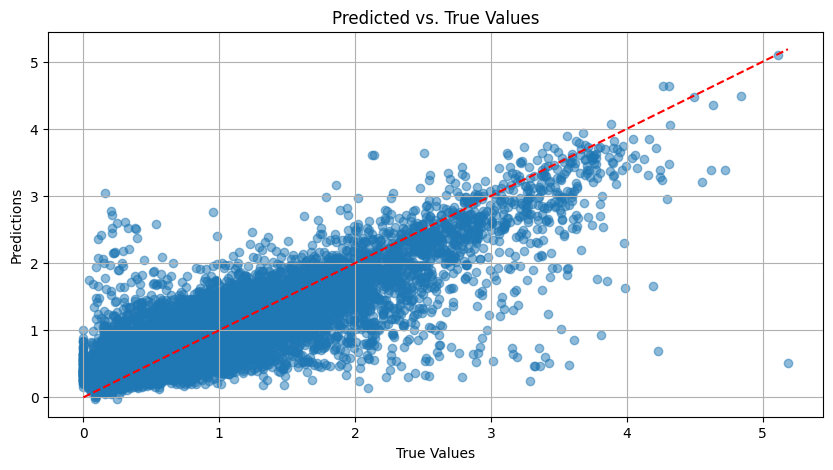

In [27]:
import matplotlib.pyplot as plt

# Make predictions on the validation set
model.eval()
with torch.no_grad():
    adt_predictions_val = model(X_val_tensor).cpu().numpy()

# Predicted vs. True Values Plot
plt.figure(figsize=(10, 5))
plt.scatter(Y_val_tensor.numpy(), adt_predictions_val, alpha=0.5)
plt.plot([Y_val_tensor.min(), Y_val_tensor.max()], [Y_val_tensor.min(), Y_val_tensor.max()], color='red', linestyle='--')  # Diagonal line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predicted vs. True Values')
plt.grid(True)
plt.savefig('predicted_vs_true.png')
plt.show()


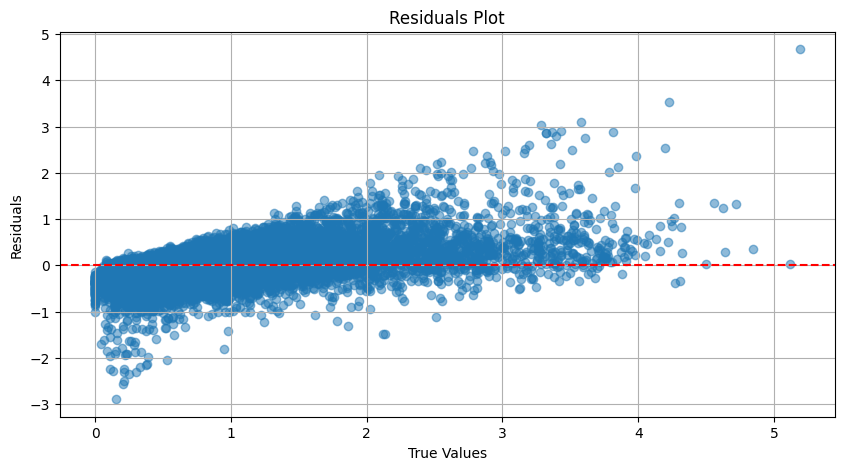

In [28]:
# Calculate residuals
residuals = Y_val_tensor.numpy() - adt_predictions_val

# Residual Plot
plt.figure(figsize=(10, 5))
plt.scatter(Y_val_tensor.numpy(), residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Line at 0
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.savefig('residuals_plot.png')
plt.show()


#### t-SNE Plot

We decided to plot a t-SNE plot to visualize how well our model is capturing the underlying latent features.

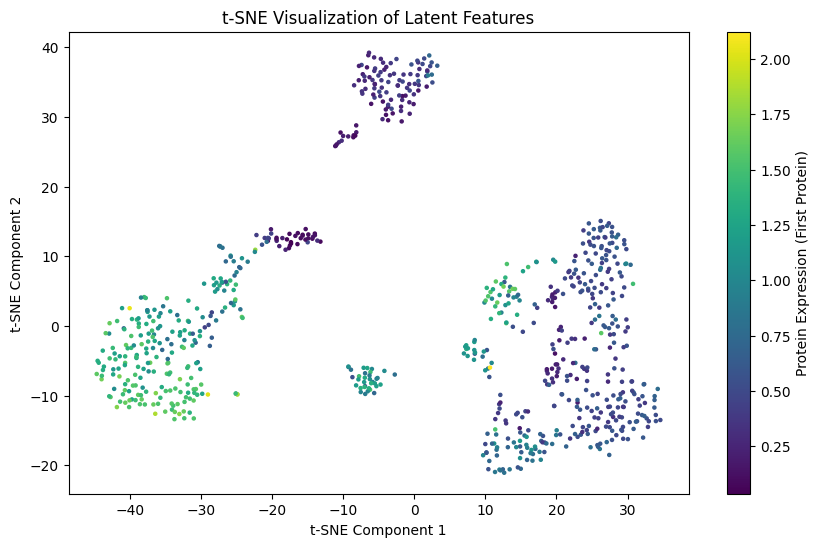

In [29]:
from sklearn.manifold import TSNE

# Get intermediate features for t-SNE visualization
model.eval()
with torch.no_grad():
    # Pass the data through each layer up to the third hidden layer to extract features
    x = model.bn1(torch.nn.functional.leaky_relu(model.fc1(X_val_tensor), negative_slope=0.01))
    x = model.bn2(torch.nn.functional.leaky_relu(model.fc2(x), negative_slope=0.01))
    intermediate_output = model.bn3(torch.nn.functional.leaky_relu(model.fc3(x), negative_slope=0.01)).cpu().numpy()

# Apply t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(intermediate_output)

# Scatter plot for t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=Y_val_tensor[:, 0], cmap='viridis', s=5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Latent Features')
plt.colorbar(label='Protein Expression (First Protein)')
plt.show()


The presence of distinct clusters suggests that the model is effectively capturing underlying relationships in the data. Each cluster may represent cells with similar protein expression or transcriptional profiles, indicating that the model is learning meaningful patterns.

#### Training and Validation Graphs

We also plotted a graph tracing the  training and validation loss

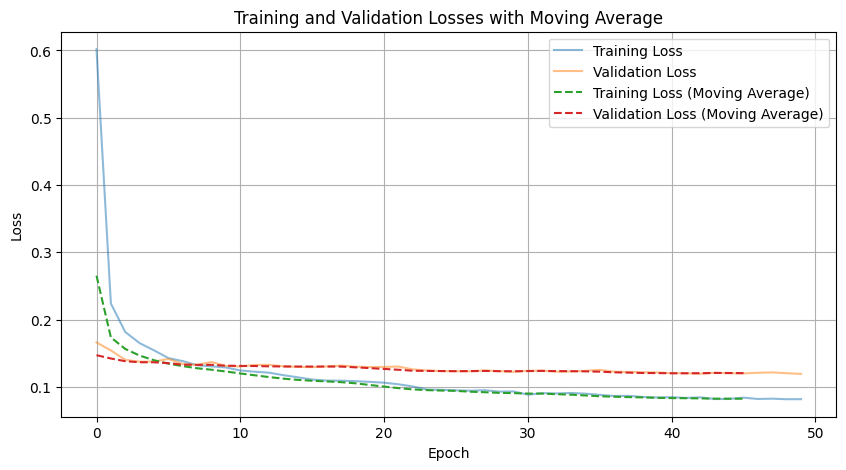

In [30]:
# Plotting training and validation losses with moving average
def moving_average(values, window=5):
    return np.convolve(values, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', alpha=0.5)
plt.plot(val_losses, label='Validation Loss', alpha=0.5)
plt.plot(moving_average(train_losses), label='Training Loss (Moving Average)', linestyle='--')
plt.plot(moving_average(val_losses), label='Validation Loss (Moving Average)', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses with Moving Average')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_losses_moving_average.png')
plt.show()


#### Weight Distribution

We also decided to plot a weight distribution over the different factors, as the model learned the features. The changes in the weights, and the weight value over time, helps visualize how the model learned the different underlying features, with some layers having skewness towards the left (positive).

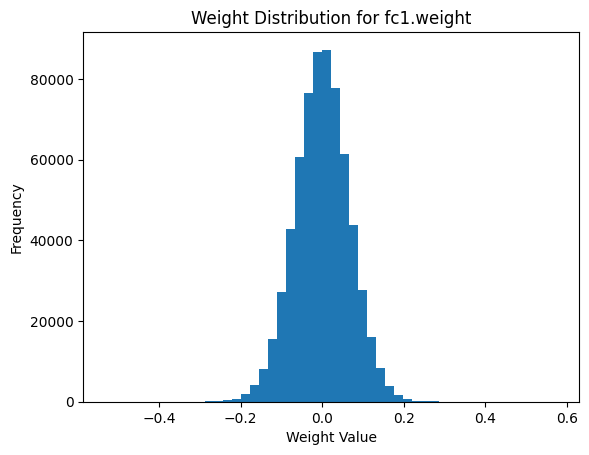

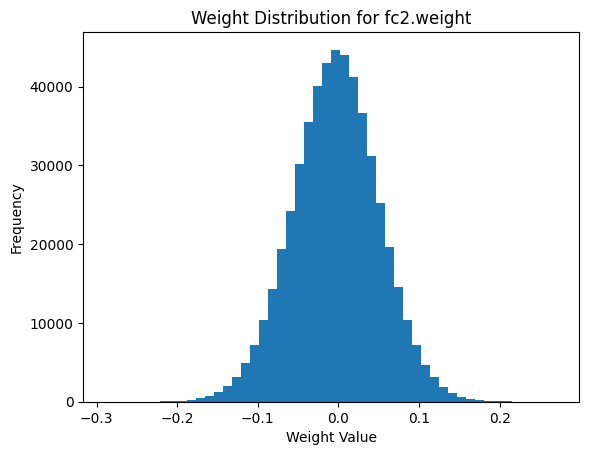

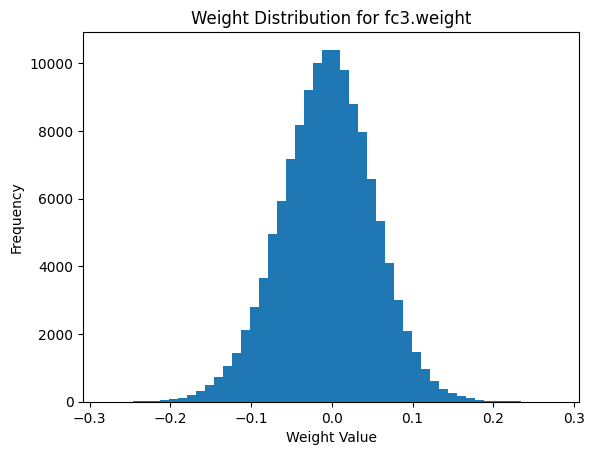

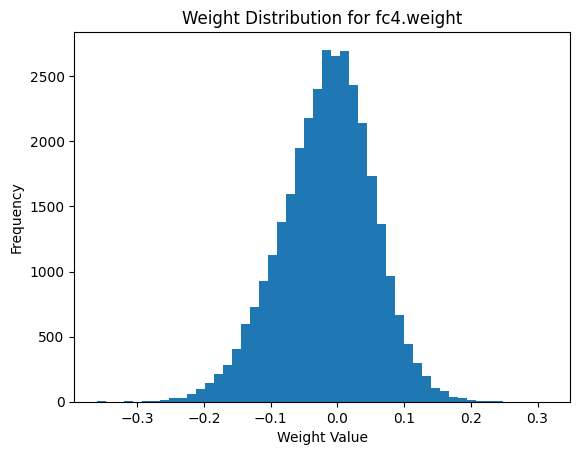

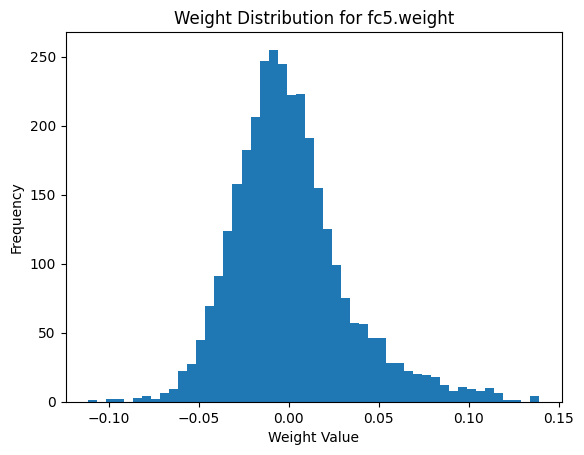

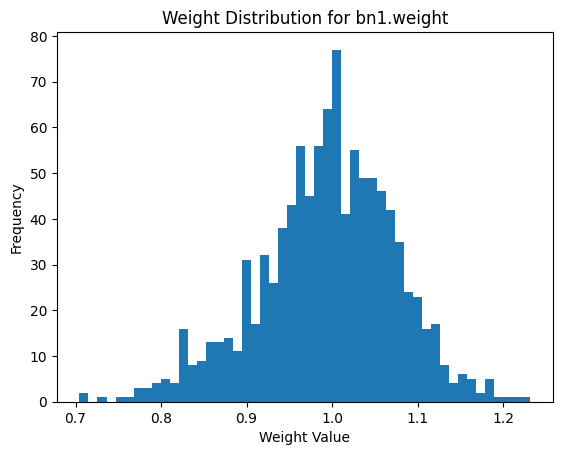

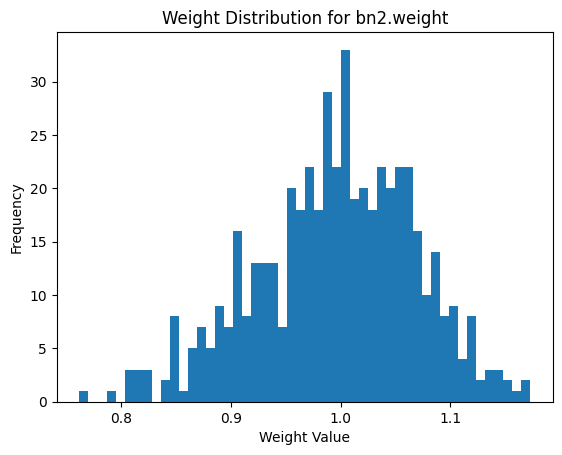

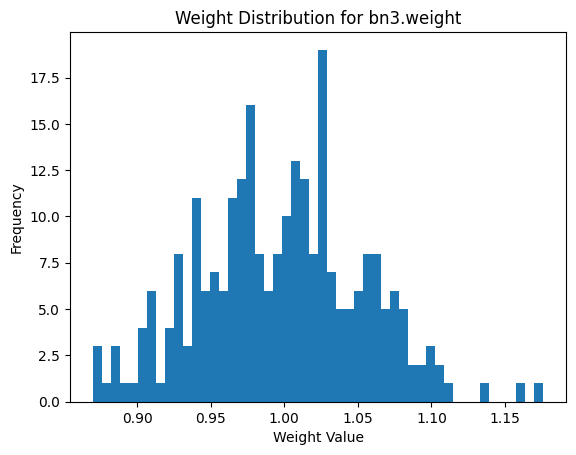

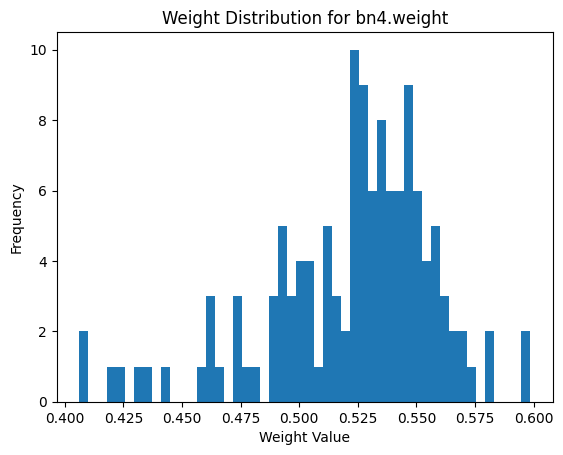

In [31]:
for name, param in model.named_parameters():
    if 'weight' in name:
        plt.figure()
        plt.hist(param.detach().cpu().numpy().flatten(), bins=50)
        plt.title(f'Weight Distribution for {name}')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.show()


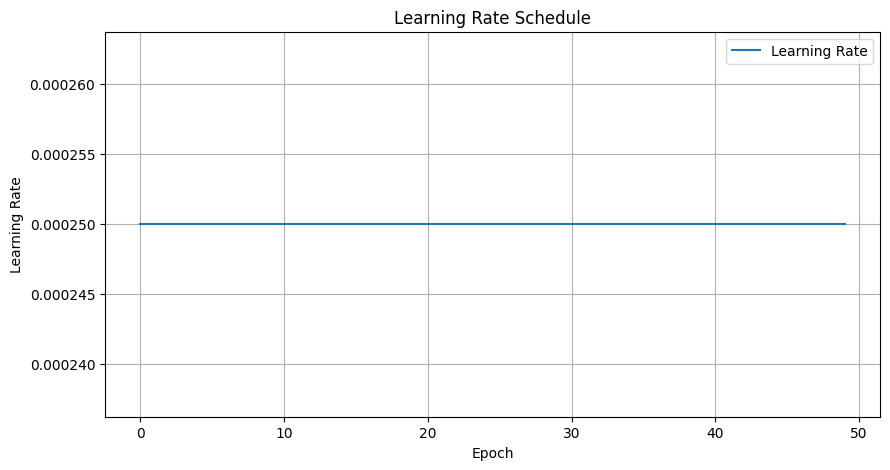

In [32]:
# Store learning rates at each epoch
learning_rates = []

for epoch in range(num_epochs):
    # Your training logic here
    learning_rates.append(optimizer.param_groups[0]['lr'])  # Store the learning rate

# Learning Rate Schedule Plot
plt.figure(figsize=(10, 5))
plt.plot(learning_rates, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.legend()
plt.savefig('learning_rate_schedule.png')
plt.show()


## NMF Implementation

 We explored the option of applying Non-Negative Matrix Factorization (NMF) to analyze and decompose our combined ADT (Antibody-Derived Target) and RNA features. By performing NMF, we aimed to uncover latent structures in the data that can enhance our understanding of the relationships between different biological measurements.

 The implementation included an alternating least squares approach to update the matrices iteratively, allowing for the extraction of meaningful patterns. Subsequently, we assessed the model's performance by calculating the Pearson correlation coefficient between the predicted and actual ADT values. We then created a submission file after getting a satisfactory pearson correlation value. Upon submission we got a **0.84965** score.

In [33]:


# Load training RNA data, ensuring the first column (index) is not treated as data
path1 = "https://raw.githubusercontent.com/irungum/CIS678/main/training_set_rna.csv"
train_rna = pd.read_csv(path1, index_col=0).values
 # Transpose to get the correct shape

# Load training ADT data, ensuring the first column (index) is not treated as data
path2 = "https://raw.githubusercontent.com/irungum/CIS678/main/training_set_adt.csv"
train_adt = pd.read_csv(path2, index_col=0).values
 # Transpose to get the correct shape

# Load test RNA data, ensuring the first column (index) is not treated as data
path3 = "https://raw.githubusercontent.com/irungum/CIS678/main/test_set_rna.csv"
test_rna = pd.read_csv(path3, index_col=0).values
 # Transpose to get the correct shape

# Check the shapes again
print('Training RNA shape:', train_rna.shape)  # Expected: (4000, 639)
print('Training ADT shape:', train_adt.shape)  # Expected: (4000, 25)
print('Test RNA shape:', test_rna.shape)          # Expected: (1000, 639)

Training RNA shape: (639, 4000)
Training ADT shape: (25, 4000)
Test RNA shape: (639, 1000)


In [34]:
# Subset the data as specified
train_rna_subset = train_rna[:,:3000]
train_adt_subset = train_adt[:,:3000]
test_rna_subset = train_rna[:,3000:]
test_adt_subset = train_adt[:,3000:]
train_adt_subset.shape,train_rna_subset.shape, test_rna_subset.shape, test_adt_subset.shape

((25, 3000), (639, 3000), (639, 1000), (25, 1000))

In [ ]:
import numpy as np

def nmf(X, k, max_iter=1000, verbose=True):
    if verbose:
        print(f"Performing NMF with k = {k}")
    # Randomly initialize W and initialize H with small positive values to prevent zero division
    np.random.seed(6495)
    W = np.random.rand(X.shape[0], k)
    H = np.zeros((k, X.shape[1])) + 1e-15

    for i in range(max_iter):
        # Update H and W alternatingly using ALS (Alternating Least Squares)
        H *= np.dot(W.T, X) / (np.dot(np.dot(W.T, W), H) + 1e-15)
        W *= np.dot(X, H.T) / (np.dot(W, np.dot(H, H.T)) + 1e-15)

    return W, H

def get_H_test(A, W, k, num_iterations=100):
    # Randomly initialize H with correct dimensions
    H_hat = np.random.rand(k, A.shape[1])

    for i in range(num_iterations):
        # Update H_hat using least squares solution
        H_hat = np.linalg.lstsq(W.T.dot(W), W.T.dot(A), rcond=None)[0]
        # Apply non-negativity constraint
        H_hat[H_hat < 0] = 0

    return H_hat

# Combine ADT and RNA features into a single matrix A
A = np.vstack((train_adt_subset, train_rna_subset))

nmf_cors = {}

# Loop over values of k to find an optimal rank for NMF
for k in range(10, 290, 10):
    W, H = nmf(A, k, verbose=False)
    H_test = get_H_test(test_rna_subset, W[25:], k)
    adt_predictions = W[:25].dot(H_test)
    # Calculate Pearson correlation for NMF predictions
    nmf_cors[k] = np.corrcoef(adt_predictions.flatten(), test_adt_subset.flatten())[0, 1]

nmf_cors



### Visualizing Our Submission

We created a graph tracing the nmf_correlation values over the 290 iterations.

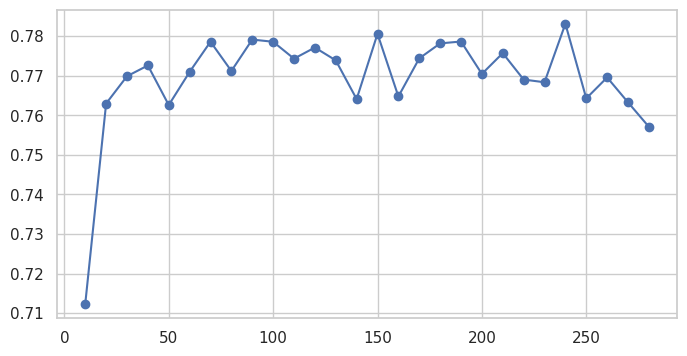

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette(None)
plt.figure(figsize=(8,4))

plt.plot(nmf_cors.keys(),nmf_cors.values(),marker="o")

In [ ]:
f"highest NMF:{sorted(nmf_cors.values())[-1]}"

'highest NMF:0.7831486681228235'

## Conclusion

In conclusion, while the linear regression model provided an initial baseline, the deep learning approach was instrumental in capturing the complex, non-linear relationships inherent in the data. By leveraging multiple hidden layers, the deep learning model was able to learn intricate patterns between RNA features and protein expression that linear regression could not. This approach demonstrated a significant improvement in prediction accuracy, highlighting the potential of deep learning in tackling multi-modal biological data. Moving forward, these findings can serve as a basis for further optimizing model performance and exploring additional deep learning architectures to enhance predictive power.